<a href="https://colab.research.google.com/github/LollaGavrishko/ML/blob/main/cat_vs_rat_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Подготовка данных для НС. Разметка

###Необходимые ресурсы

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from google.colab import files
import zipfile
import io, shutil


###Загрузка обучающей выборки

In [ ]:
# загрузка содержания Google диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# загрузим файл Dataset с Google диска
!cp '/content/drive/MyDrive/Dataset.zip' Dataset.zip

In [ ]:
# проверим, что файлы загрузились
!ls

Dataset  Dataset.zip  drive  sample_data


In [ ]:
# распакуем датасет
!unzip Dataset.zip

Archive:  Dataset.zip
replace Dataset/kot1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Dataset/kot1.jpg        
  inflating: Dataset/kot2.jpg        
  inflating: Dataset/kot3.jpg        
  inflating: Dataset/kot4.jpg        
  inflating: Dataset/kot5.jpg        
  inflating: Dataset/kot6.jpg        
  inflating: Dataset/kris1.jpg       
  inflating: Dataset/kris2.jpg       
  inflating: Dataset/kris3.jpg       
  inflating: Dataset/kris4.jpg       
  inflating: Dataset/kris5.jpg       
  inflating: Dataset/kris6.jpg       


In [ ]:
# подсчитаем количество файлов в датасете
!find /content/Dataset -type f| wc -l

12


###Разметка
Определим изображение с подписью в категорию - 1, с текстом - в 0.

In [ ]:
filenames = os.listdir("../content/Dataset")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if 't' in category:
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': categories
})

In [ ]:
# посмотрим на первые 10 записей
df.head(10)

,filename,label
0,kris5.jpg,1
1,kot1.jpg,0
2,kot6.jpg,0
3,kot4.jpg,0
4,kot5.jpg,0
5,kot2.jpg,0
6,kot3.jpg,0
7,kris6.jpg,1
8,kris4.jpg,1
9,kris2.jpg,1


In [ ]:
# общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12 non-null     object
 1   label     12 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 320.0+ bytes


In [ ]:
# подсчитаем количество файлов с подписями
# так как колонка label состоит только их 0 и 1, то общая сумма = количеству изображений, определенных как подпись
df['label'].sum(axis=0)

6

###Посмотрим на распределение изображений

<Axes: >

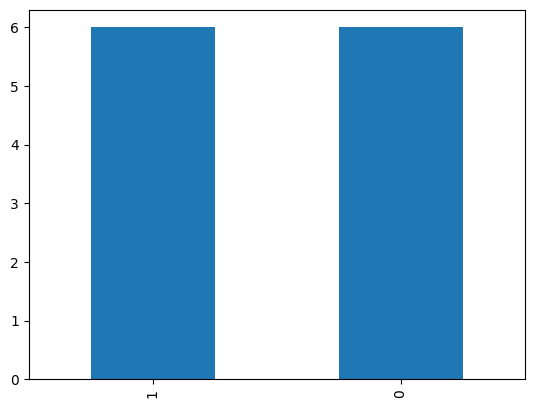

In [ ]:
df['label'].value_counts().plot.bar()

###Посмотрим на случайное изображение из датасета

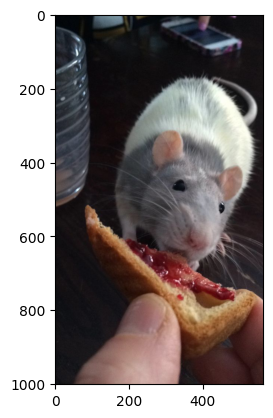

In [ ]:
sample = random.choice(filenames)
image = load_img("../content/Dataset/" + sample)
plt.imshow(image)

###Сформируем обучающую и проверочную выборку

Будем использовать image generator с class_mode = "categorical", нам нужно преобразовать категорию столбца в тип объекта - строка.

Затем imagenerator преобразует строки в one-hot encoding для решения задачи классификации.

Таким образом, мы будем конвертировать 1 в 'подпись' и 0 - в 'текст'.

In [ ]:
df["label"] = df["label"].replace({0: 'котики', 1: 'крысы'})

In [ ]:
# сформируем обучающую и проверочную выборку
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=78)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_df

,filename,label
0,kris3.jpg,крысы
1,kot5.jpg,котики
2,kris5.jpg,крысы
3,kris1.jpg,крысы
4,kot1.jpg,котики
5,kris4.jpg,крысы
6,kris6.jpg,крысы
7,kot3.jpg,котики
8,kot2.jpg,котики


In [ ]:
validate_df

,filename,label
0,kot4.jpg,котики
1,kris2.jpg,крысы
2,kot6.jpg,котики


<Axes: >

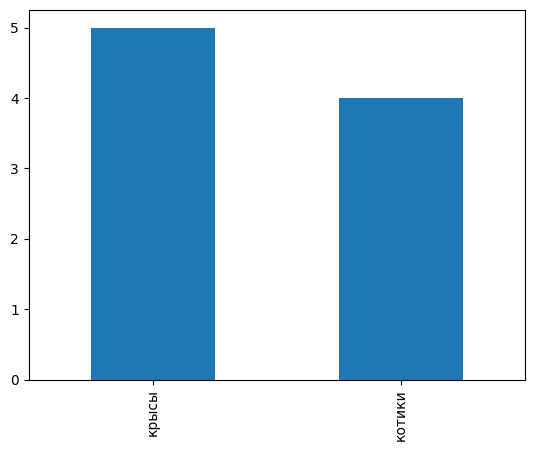

In [ ]:
# посмотрим на распределение обучающей выборки
train_df['label'].value_counts().plot.bar()

<Axes: >

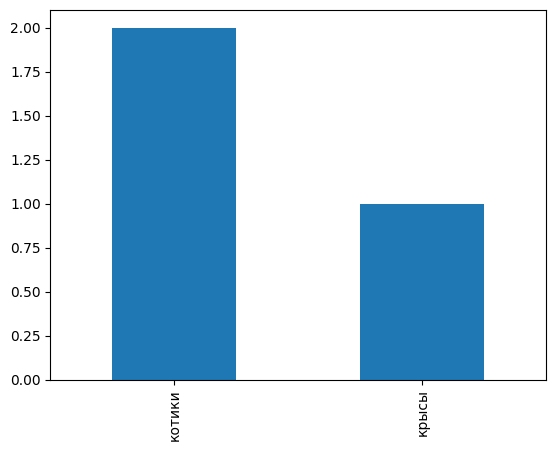

In [ ]:
# посмотрим на распределение проверочной выборки
validate_df['label'].value_counts().plot.bar()

In [ ]:
train_df.head()

,filename,label
0,kris3.jpg,крысы
1,kot5.jpg,котики
2,kris5.jpg,крысы
3,kris1.jpg,крысы
4,kot1.jpg,котики


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9 non-null      object
 1   label     9 non-null      object
dtypes: object(2)
memory usage: 272.0+ bytes


In [ ]:
# (число строк, число столбцов)
train_df.shape

(9, 2)

In [ ]:
# всего данных
train_df.size

18

In [ ]:
# число строк
len(train_df)

9

In [ ]:
# запишем количество данных для обучения и проверки в переменные
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
# определим batch_size
batch_size=15

In [ ]:
total_train

9

In [ ]:
total_validate

3

###ImageDataGenerator для обучающей и проверочной выборок
- Применим ImageDataGenerator для трансформации изображений для обучающей выборки

In [ ]:
# Определим константы
#FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "../content/Dataset/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 9 validated image filenames belonging to 2 classes.


In [ ]:
# Применим ImageDataGenerator для трансформации изображений для проверочной выборки

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "../content/Dataset/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3 validated image filenames belonging to 2 classes.


####Посмотрим на пример трансформации изображения

In [ ]:
example_df = train_df.sample(n=2).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "../content/Dataset/",
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 2 validated image filenames belonging to 1 classes.


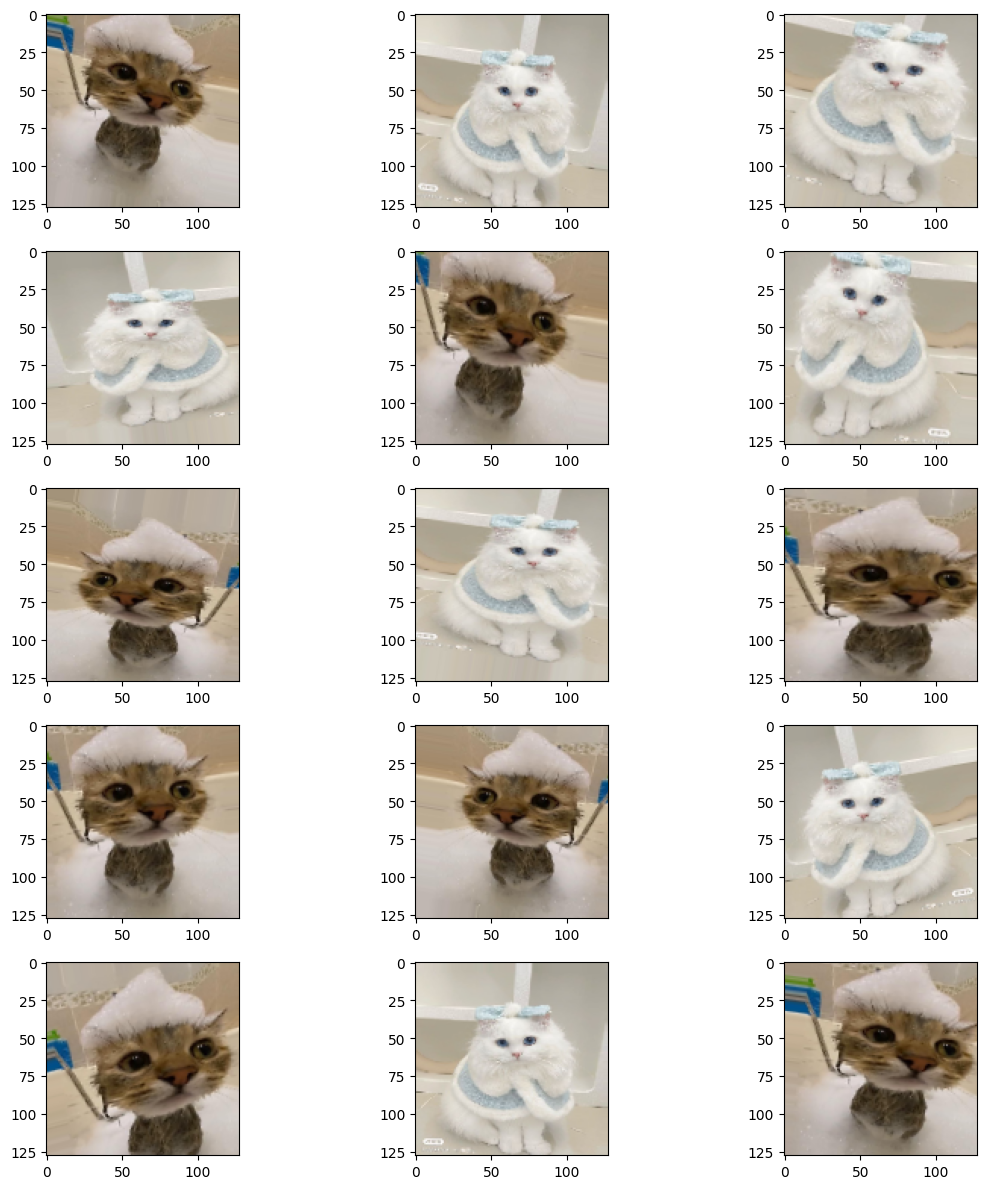

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15): # (0, 3) количество изображений
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        #print(X_batch[0])
        #print(Y_batch)
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

####Задание
1. Повторить блокнот с готовым датасетом Dataset.zip
2. Выполнить разметку и разделение выборок на обучающую и проверочную для своего датасета.